In [16]:
from PIL import Image
import matplotlib.pyplot as plt
from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg 
import requests
import zipfile
import os
import random
import glob

In [28]:
config = Cfg.load_config_from_name("vgg_seq2seq")

In [29]:
config['predictor']['beamsearch'] = True  # Enable beam search for better accuracy
config['device'] = 'cpu'
detector = Predictor(config)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to C:\Users\ADMIN/.cache\torch\hub\checkpoints\vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [01:26<00:00, 6.65MB/s] 
10935it [00:15, 713.66it/s]


In [13]:
url = "https://vocr.vn/data/vietocr/sample.zip"
zip_file = "sample.zip"

In [14]:
# print("Downloading the file...")
# response = requests.get(url)
# with open(zip_file, 'wb') as f:
#     f.write(response.content)
# print("Download complete!")

# print("Unzipping the file...")
# with zipfile.ZipFile(zip_file, 'r') as zip_ref:
#     zip_ref.extractall(os.getcwd())
# print("Unzipping complete!")

Download complete!
Unzipping the file...
Unzipping complete!


In [17]:
directory = 'sample'

# List all files in the directory
files = glob.glob(os.path.join(directory, '*'))

random.shuffle(files)
selected_files = files[:5]
for file in selected_files:
    print(file)

sample\deskewed-_2019_10_03_20191003002690_2019100308491067310_4.jpg
sample\026087002892.jpeg
sample\001195005971.jpeg
sample\00019816.jpg
sample\033303003954.jpeg


Result is = VŨ THUỲ NINH


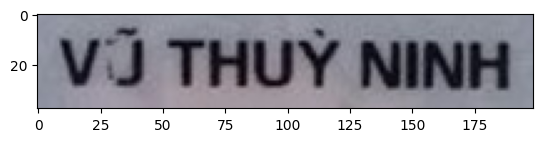

In [30]:
img ="./sample/031189003299.jpeg"
img = Image.open(img)
plt.imshow(img)
s = detector.predict(img)
print(f"Result is = {s}")

Result is = E


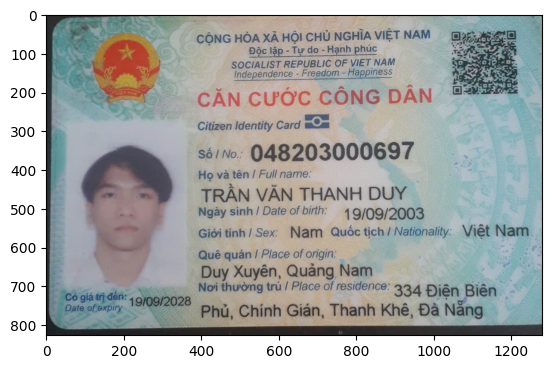

In [31]:
img = Image.open("cccd.jpg")
plt.imshow(img)
s = detector.predict(img)
print(f"Result is = {s}")